# Agents issus de la littérature

In [1]:
from atom import *
from data_processing import *
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stats
plt.rcParams['figure.figsize'] = (15,10)

### ZIT

Gode et Sunder en 1993 ont permis d'expliciter qu'un certain nombre de comportements observables sur un marché réel ne sont pas dus à la rationalité de ses participants mais apparaissent même avec des participants au comportement aléatoire. Ils ont ainsi introduit le ZIT, Zero Intelligence Trader, qui est un agent aléatoire : avec seulement un intervalle de prix possibles, un intervalle de quantité à échanger et éventuellement une probabilité d'échanger, ces agents choisissent aléatoirement des échanges à effectuer.

In [2]:
class ZITTrader_v2(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "ZITv2 " + super().__str__()
    def decide_order(self, market, asset):
        # On compte le nombre d'ordres placés dans les orderbooks par cet agent...
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK' and self.assets[asset] > 0: # Si on a quantité > 0 d'actions pour cet asset...
                # On ne vend pas une quantité d'actions > à celle qu'on a.
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 1000: # Pour acheter, il faut de l'argent...
                price = random.randint(1000, min(self.cash, 9999))
                # On n'achète pas pour un volume > au cash qu'on a.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # Dans tous les autres cas, on ne place pas d'ordre.
    
class ZITPeriodique(Trader):
    def __init__(self, market, initial_assets=None, cash=0, periode=1):
        Trader.__init__(self, market, initial_assets, cash)
        self.periode = periode
    def __str__(self):
        return "ZITdelta %i" % self.trader_id
    def decide_order(self, market, asset):
        
        if ((market.time+1)%self.periode==0):
            return LimitOrder(asset, self, random.choice(['ASK', 'BID']), random.randint(1000,9999), random.randint(1, 9))
        else:
            return None 

Ces agents se basent à l'origine sur un modèle client - trader : le client demande au trader de passer des ordres à un prix v et le trader essaye de maximiser son profit par rapport à ce prix et au marché.
Atom ne suit pas ce modèle et le prix v demandé par le client est donc simulé par une estimation de la valeur fondamentale du produit.

### ZIC : Zero-Intelligence Constrained Traders

Ces traders n'achètent qu'à des prix aléatoires supérieurs et ne vendent qu'à des prix aléatoires inférieurs à la valeur de v.

In [38]:

# v = hash table of redemption value i.e. dic des valeurs fondamentales perçues
class ZIC(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000,waitmax=np.random.randint(3,20)):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.wait = -1
        self.waitmax = waitmax
    def __str__(self):
        return "ZIC " + super().__str__()
    def decide_order(self, market, asset):
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        self.wait+=1
        if (self.wait%self.waitmax) == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK':
                return LimitOrder(asset, self, 'ASK', random.randint(self.v[asset], 9999), random.randint(1, 9))
            elif direction == 'BID':
                return LimitOrder(asset, self, 'BID', random.randint(1000, self.v[asset]), random.randint(1, 9))
        return None

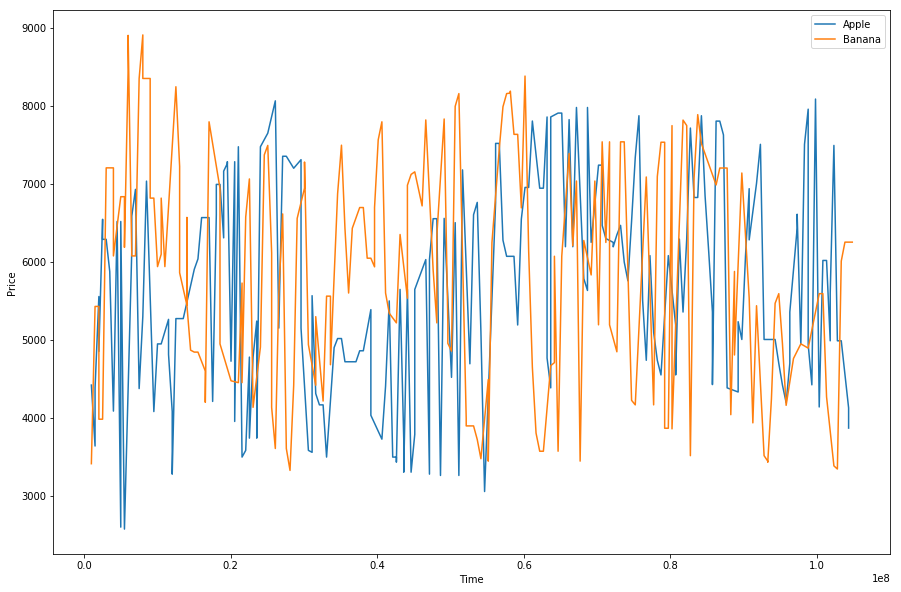

Wealth moyen ZIT : -9514.0
Wealth moyen ZIC : 9514.0


In [11]:
file = open('mytrace.dat', 'w')
#m = Market(['Apple', 'Google'], out=file, fix='S')
m = Market(['Apple','Banana'], out=file, fix='S')

ZITs = []
ZICs = []

for i in range(5):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
    
    t = ZIC(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    ZICs.append(t)
    m.add_trader(t)
    
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)
    
for i in range(100):
    m.run_once()
file.close()
plt.rcParams['figure.figsize'] = (15,10)
Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

ZIT_wealths = []
ZIC_wealths = []
for i in range(len(ZITs)):
    ZIT_wealths.append(ZITs[i].get_wealth(m))
    ZIC_wealths.append(ZICs[i].get_wealth(m))
print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
print("Wealth moyen ZIC :",np.mean(ZIC_wealths))

### ZIP : Zero-Intelligence-Plus Traders

Ces traders optimisent leur marge de profit en fonction du dernier prix grâce à de l'apprentissage : si il est proche de v, la marge sera réduite (car un ordre proposé à un prix trop éloigné de v ne trouvera pas de preneur), sinon elle sera augmentée (car un ordre proposé à un prix trop proche de v empêche des profits potentiels). 

In [12]:
# v = redemption value i.e. valeur fondamentale perçue
class ZIPab(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000, momentum=0.5, beta=0.3):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.price = -1
        self.marginA = 0
        self.prev_changeA = 0
        self.marginB = 0
        self.prev_changeB = 0
        self.momentum = momentum # momentum [0 - 1] i.e. coeff of importance of past change
        self.beta = beta #  learning rate [0.1 - 0.5]
    def __str__(self):
        return "ZIPab " + super().__str__()
    def decide_order(self, market, asset):
        
        def update_margin(direction):
            P = market.prices_hist[asset]
            if len(P)>=1:
                q = P[-1]
                if self.price == -1:
                    self.price = q
                diff = q - self.price
                
                if (direction=='ASK'):
                    change = ((1.0-self.momentum)*(self.beta*diff)) + (self.momentum*self.prev_changeA) 
                    self.prev_changeA = change
                    new_marg = ((self.price + change)/self.v[asset]) - 1.0
                    self.marginA = new_marg
                else:
                    change = ((1.0-self.momentum)*(self.beta*diff)) + (self.momentum*self.prev_changeB)
                    self.prev_changeB = change
                    new_marg = ((self.price + change)/self.v[asset]) - 1.0
                    self.marginB = new_marg
        
        
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            update_margin(direction)
            if direction=='ASK':
                #print('ASK - margin:',self.marginA)
                return LimitOrder(asset, self, direction, int(self.v[asset]*(1+self.marginA)), random.randint(1, 9))
            else:
                #print('BID - margin:',self.marginB)
                return LimitOrder(asset, self, direction, int(self.v[asset]*(1+self.marginB)), random.randint(1, 9)) 
        return None
    
    
class ZIP(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000, momentum=0.5, beta=0.3):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.price = -1
        self.margin = 0
        self.prev_change = 0
        self.margin
        self.prev_change
        self.momentum = momentum # momentum [0 - 1] i.e. coeff of importance of past change
        self.beta = beta #  learning rate [0.1 - 0.5]
    def __str__(self):
        return "ZIP " + super().__str__()
    def decide_order(self, market, asset):
        
        def update_margin():
            P = market.prices_hist[asset]
            if len(P)>=1:
                q = P[-1]
                if self.price == -1:
                    self.price = q
                diff = q - self.price
                change = ((1.0-self.momentum)*(self.beta*diff)) + (self.momentum*self.prev_change) 
                self.prev_change = change
                new_marg = ((self.price + change)/self.v[asset]) - 1.0
                self.margin = new_marg
        
        
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            update_margin()
            return LimitOrder(asset, self, direction, int(self.v[asset]*(1+self.margin)), random.randint(1, 9))
        return None

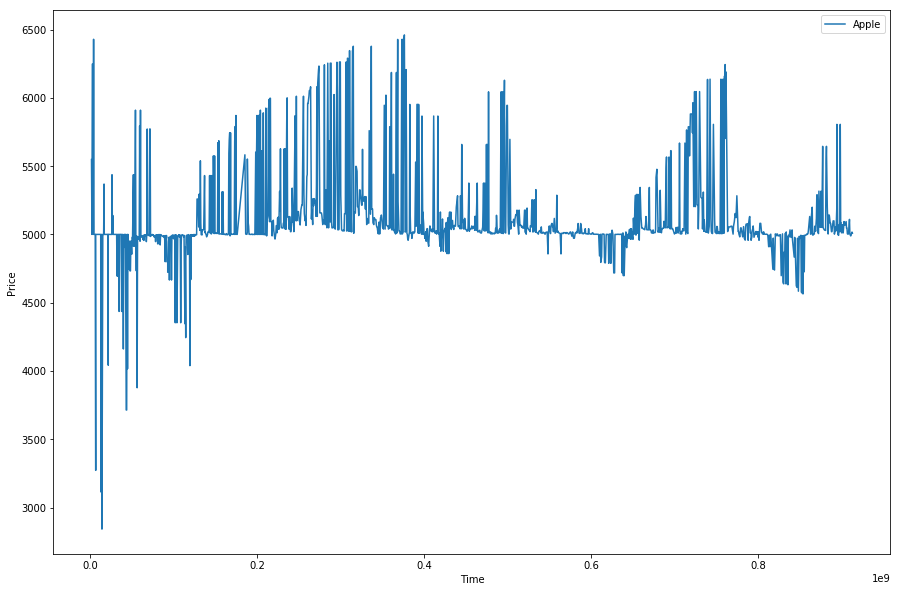

Wealth moyen ZIT : -7939.55
Wealth moyen ZIC : 2228.65
Wealth moyen ZIP : 5710.9


In [13]:
file = open('mytrace.dat', 'w')
#m = Market(['Apple', 'Google'], out=file, fix='S')
m = Market(['Apple','Banana'], out=file, fix='S')
m = Market(['Apple'], out=file, fix='S')

ZITs = []
ZICs = []
ZIPs = []

for i in range(20):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
    
    t = ZIC(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    ZICs.append(t)
    m.add_trader(t)
    
    t = ZIP(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)},momentum=random.random(),beta=(random.random()*0.4)+0.1)
    ZIPs.append(t)
    m.add_trader(t)
    
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)
    
for i in range(100):
    m.run_once()
file.close()

plt.rcParams['figure.figsize'] = (15,10)
Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

ZIT_wealths = []
ZIC_wealths = []
ZIP_wealths = []

for i in range(len(ZITs)):
    ZIT_wealths.append(ZITs[i].get_wealth(m))
    ZIC_wealths.append(ZICs[i].get_wealth(m))
    ZIP_wealths.append(ZIPs[i].get_wealth(m))
print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
print("Wealth moyen ZIC :",np.mean(ZIC_wealths))
print("Wealth moyen ZIP :",np.mean(ZIP_wealths))

### GDX
  
En 2002, Tesauro et Bredin ont créé un agent basé sur une fonction de croyance, c'est à dire la fonction qui donne la probabilité qu'ordre soit rempli. Pour une direction donnée, l'agent regarde l'historique des échanges et en déduit sa fonction de croyance. Si les ventes avant l'instant t se sont majoritairement effectuées très proche d'un prix p', il est inutile de chercher un grand profit avec un prix p de vente très supérieur à p' ou d'achat très inférieur : la probabilité que l'ordre trouve preneur est très faible. Il est donc préférable d'envoyer un ordre à un prix p proche de p', quitte à sacrifier en profit. Pour calculer la valeur exacte de p, il est facile à partir de la fonction de croyance et de v de déduire l'espérance de chaque prix possible. Le prix ayant l'espérance maximale correspond au prix qui soit à la fois assez proche des derniers prix pour que la chance que l'ordre trouve preneur soit grande et assez éloigné pour minimiser le compromis vis à vis du profit. Ce calcul de prix est relancé à chaque tour de parole de l'agent en fonction d'un historique qui est souvent partiel (n derniers prix fixés).

In [7]:
P = m.prices_hist["Apple"]

def f_belief(market,asset,p,direction):
    P = market.prices_hist[asset]
    aag = 0
    abl = 0
    for price in P:
        if price>=p:
            aag+=1
        else:
            abl+=1
    book = market.orderbooks[asset]
    asks = book.asks.tree
    bids = book.bids.tree
    ual = 0
    for ask in asks:
        if ask.price <= p:
            ual+=1
    ubg = 0
    for bid in bids:
        if bid.price >= p:
            ubg+=1
    if direction=='ASK':
        if (2*aag + ubg + ual)==0:
            return 0
        return ((2*aag + ubg) / (2*aag + ubg + ual))
    else:
        if (2*abl + ual + ubg)==0:
            return 0
        return ((2*abl + ual) / (2*abl + ual + ubg))

In [51]:
class GDX(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000,waitmax=np.random.randint(3,20)):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.wait = -1
        self.waitmax = waitmax
    def __str__(self):
        return "GDX " + super().__str__()
    def decide_order(self, market, asset):
        directionAbs = {'ASK':1,'BID':-1}
        self.wait+=1
        
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        if (self.wait%self.waitmax) == 0:
            direction = random.choice(['ASK', 'BID'])
            
            expected_surplus = lambda p : directionAbs[direction]*(p-self.v[asset])*f_belief(market,asset,p,direction) # probabilty price p of a certain direction is accepted 
            #print("res",expected_surplus(p),"f",f_belief(market,asset,p,direction),"p",p,"l",self.v[asset],direction)                     
            prices = np.concatenate((np.linspace(1000,3000,201),np.linspace(3001,7000,4000),np.linspace(7009,9999,300))) # pour 400 prix entre 3000 et 7000 
            exp_s  = np.array([expected_surplus(p) for p in prices]) # on calcule l'espérence de profit grâce à la fonction de belief
            p = prices[np.argmax(exp_s)] # on récupère le prix qui a l'espérence max
            return LimitOrder(asset, self, direction, p, random.randint(1, 9)) # limitorder à ce prix
            self.wait=0

        return None

In [55]:
np.random.randint(3,20)

18

In [30]:
prices = np.concatenate((np.linspace(1000,3000,201),np.linspace(3001,7000,4000),np.linspace(7009,9999,300)))

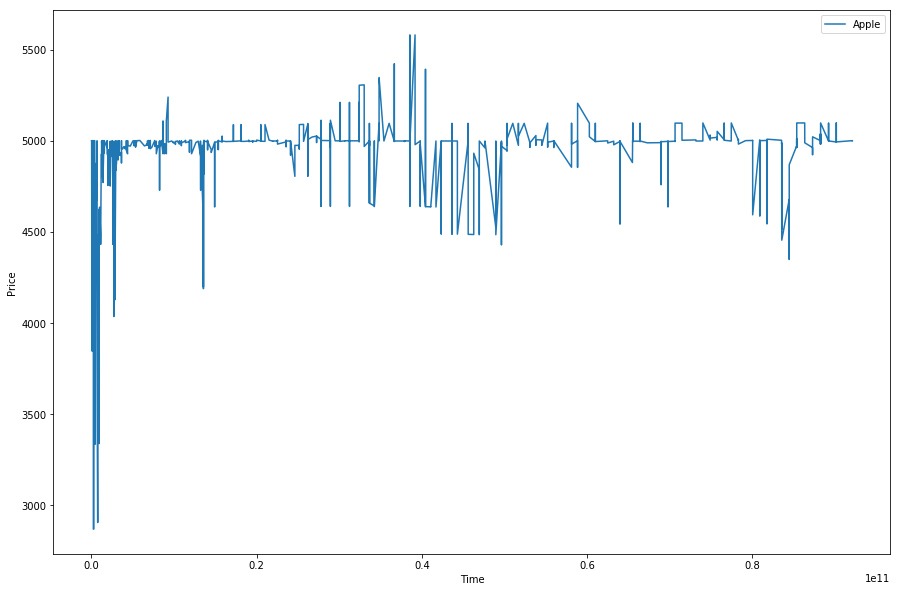

Wealth moyen ZIT : -10165.8
Wealth moyen ZIC : 1589.8
Wealth moyen ZIP : 1586.2
Wealth moyen GDX : 6989.8
Perceived wealth moyen ZIC : 2886.1
Perceived wealth moyen ZIP : 20237.25
Perceived wealth moyen GDX : 10027.15


In [31]:
plt.rcParams['figure.figsize'] = (15,10)
    
file = open('mytrace.dat', 'w')
#m = Market(['Apple', 'Google'], out=file, fix='S')
m = Market(['Apple','Banana'], out=file, fix='S')
m = Market(['Apple'], out=file, fix='S')

ZITs = []
ZICs = []
ZIPs = []
GDXs = []

for i in range(20):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
    
    t = ZIC(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    ZICs.append(t)
    m.add_trader(t)
    
    t = ZIP(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)},momentum=random.random(),beta=(random.random()*0.4)+0.1)
    ZIPs.append(t)
    m.add_trader(t)
    
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)
    
    t = GDX(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    GDXs.append(t)
    m.add_trader(t)
    
for i in range(100):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

ZIT_wealths = []
ZIC_wealths = []
ZIP_wealths = []
GDX_wealths = []

for i in range(len(ZITs)):
    ZIT_wealths.append(ZITs[i].get_wealth(m))
    ZIC_wealths.append(ZICs[i].get_wealth(m))
    ZIP_wealths.append(ZIPs[i].get_wealth(m))
    GDX_wealths.append(GDXs[i].get_wealth(m))

ZIC_perceived_wealths = []
ZIP_perceived_wealths = []
GDX_perceived_wealths = []

for i in range(len(ZICs)):
    a = ZICs[i]
    pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
    ZIC_perceived_wealths.append(pw)
    a = ZIPs[i]
    pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
    ZIP_perceived_wealths.append(pw)
    a = GDXs[i]
    pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
    GDX_perceived_wealths.append(pw)

print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
print("Wealth moyen ZIC :",np.mean(ZIC_wealths))
print("Wealth moyen ZIP :",np.mean(ZIP_wealths))
print("Wealth moyen GDX :",np.mean(GDX_wealths))

print("Perceived wealth moyen ZIC :",np.mean(ZIC_perceived_wealths))
print("Perceived wealth moyen ZIP :",np.mean(ZIP_perceived_wealths))
print("Perceived wealth moyen GDX :",np.mean(GDX_perceived_wealths))


Le wealth est basé sur le dernier prix fixé, le perceived wealth sur le prix cible de l'agent (v). Logiquement, les perceived wealth sont supérieurs aux wealths dans tous la plupart des cas. L'écart est cependant variable pour les différentes stratégies : certaines s'approchent plus de leurs prix cibles que d'autres, qui préfèrent ne pas trop s'éloigner du prix moyen.

#### 20 GDX + 60 ZIT

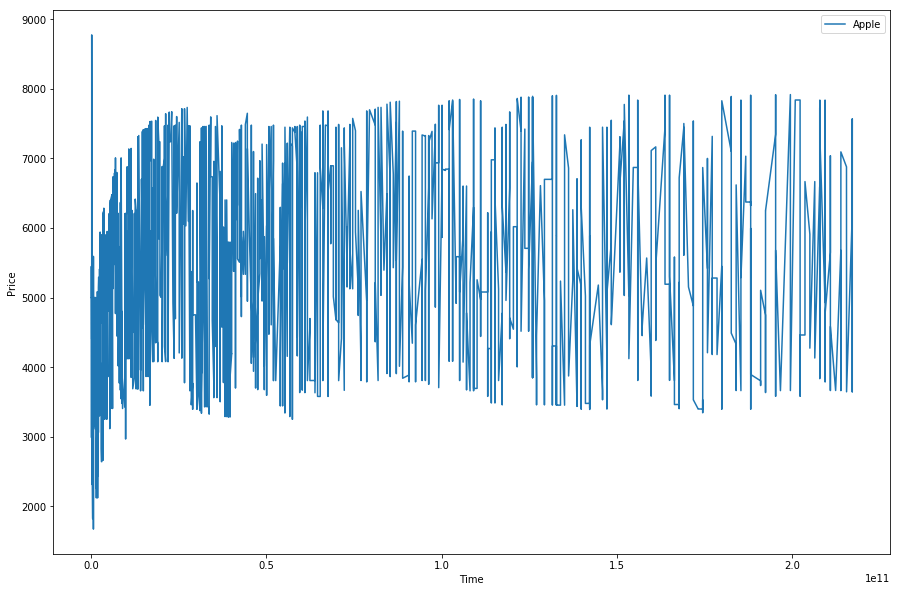

Wealth moyen ZIT : -39264.816666666666
Wealth moyen GDX : 117794.45


In [32]:
plt.rcParams['figure.figsize'] = (15,10)


file = open('mytrace.dat', 'w')
#m = Market(['Apple', 'Google'], out=file, fix='S')
m = Market(['Apple','Banana'], out=file, fix='S')
m = Market(['Apple'], out=file, fix='S')

ZITs = []
ZICs = []
ZIPs = []
GDXs = []

for i in range(20):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
    for j in range(3):
        t = ZITTrader(m)
        ZITs.append(t)
        m.add_trader(t)
    
    t = GDX(m,v={'Apple':random.randint(0,9999),'Banana':random.randint(0,9999)})
    GDXs.append(t)
    m.add_trader(t)
    
for i in range(100):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

ZIT_wealths = []
GDX_wealths = []

for i in range(len(ZITs)):
    ZIT_wealths.append(ZITs[i].get_wealth(m))
for i in range(len(GDXs)):
    GDX_wealths.append(GDXs[i].get_wealth(m))
print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
print("Wealth moyen GDX :",np.mean(GDX_wealths))

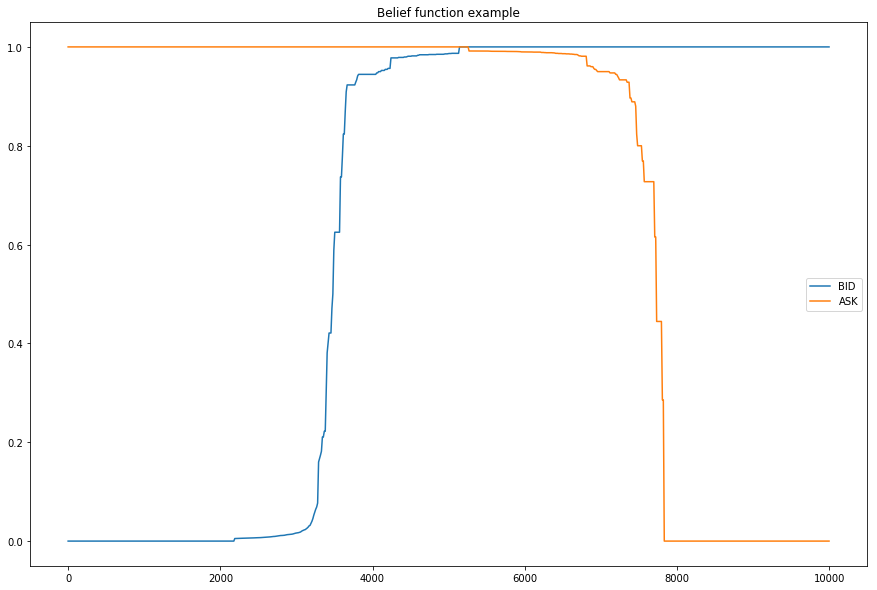

État de la fonction de croyance à la fin du marché lancé précédemment


In [33]:
plt.rcParams['figure.figsize'] = (15,10)

x = np.linspace(0,9999,800)
y = np.array([f_belief(m,"Apple",xi,'BID') for xi in x])
plt.plot(x,y,label="BID")
y = np.array([f_belief(m,"Apple",xi,'ASK') for xi in x])
plt.plot(x,y,label="ASK")
plt.title("Belief function example")
plt.legend()
plt.show()
print("État de la fonction de croyance à la fin du marché lancé précédemment")


### AA : Adaptative Aggressive traders

Vytelingum, Cliff et Jennings ont proposé l'agent AA (Adaptive Aggressive). Cet agent repose sur l'apprentissage automatique pour faire varier un paramètre d'agressivité. Ce paramètre varie au cours du temps et s'adapte en fonction des ordres acceptés dans l'historique. La stratégie de l'agent se situe donc entre une stratégie très agressive où l'agent va prendre des risques jusqu'à acheter ou vendre à perte (en fonction de son prix fixé) ou être passif et chercher à échanger avec le plus fort profit, quelle que soit la probabilité que l'ordre trouve preneur. <img src="agg.png" alt="drawing" width="500"/> Les courbes de cette figure permettent de visualiser les prix possibles en fonction de différentes valeurs d'agressivité. Ces courbes dépendent également du paramètre $\theta$ qui représente la fréquence d'apprentissage de l'agressivité. Une faible valeur correspond à une accentuation de l'agressivité et est adaptée à un marché rapide, qui vient par exemple d'être lancé ou de connaître une forte et soudaine variation de prix. Une forte valeur au contraire correspond à une atténuation de l'agressivité et est adaptée à un marché stable.

In [ ]:
# weighted moving average 
# for N last prices
# T is the last price
# each weight is worth rho times what the one after that is worth
# 0<rho<1 so each weight is worth less as it gets further in the price history from the last price
# weights are normalised so sum is 1

def get_weights(N_last_prices,rho=0.9):
    w = np.empty(N_last_prices)
    w[-1] = 1
    for i in range(2,N_last_prices+1):
        w[N_last_prices-i] = w[N_last_prices-i+1]*rho
    w = w/sum(w)
    return w

def get_wma(market,asset,N_last_prices,rho):
    P = market.prices_hist[asset]
    if len(P)>N_last_prices:
        H = P[-N_last_prices:]
    else:
        H = P
        N_last_prices = len(H)
    w = get_weights(N_last_prices,rho)
    wma = sum(w*H)
    return wma

print(get_wma(m,'Apple',10,0.9))
print(get_wma(m,'Apple',100,1))
print(get_wma(m,'Apple',100,.9))


In [ ]:
class AA(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000, N_last_prices = 20, rho=0.9 ,aatype = "extra", maxprice={"Apple":9999},beta={"Apple":0.4}):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.N_last_prices = N_last_prices
        self.rho = rho
        self.beta = beta
        
        self.r_b = {}
        self.theta_b = {}
        self.thetabar_b = {}
        
        self.r_s = {}
        self.theta_s = {}
        self.thetabar_s = {}
        
        
        self.aatype = {}
        self.maxprice = {}
        self.first = {}

        for asset in market.orderbooks:
            # Buyers parameters
            self.r_b[asset] = 0 # tmp
            self.theta_b[asset] = 2 # tmp 
            self.thetabar_b[asset] = 2 # ?? tmp
        
            # Sellers parameters
            self.r_s[asset] = 0 # tmp
            self.theta_s[asset] = 2 # tmp 
            self.thetabar_s[asset] = 2 # ?? tmp
        
            self.aatype[asset] = aatype # ( extra | intra )
            self.maxprice[asset] = maxprice
            self.first[asset] = True

        
    def __str__(self):
        return "AA " + super().__str__()
    
    def get_target_price(self,wma,direction,asset):
        
        # INTRA-MARGINAL - ie peut acheter
        
        if self.aatype == "intra":
            
            # BUYER
            
            if direction == "BID":
                if self.r_b<0:   # r ∈ (− 1 , 0 )
                    tau = wma*(1-(np.exp(-self.r_b*self.thetabar_b)-1)/(np.exp(self.thetabar_b)-1))
                else:          # r ∈ (0 , 1 )
                    tau = wma + (self.v[asset]-wma)*((np.exp(self.r_b*self.theta_b)-1)/(np.exp(self.theta_b)-1))
            
            # SELLER
            
            else:
                if self.r_s<0:   # r ∈ (− 1 , 0 )
                    tau = wma + (self.maxprice[asset]-wma)*(np.exp(-self.r_s*self.thetabar_s)-1)/(np.exp(self.thetabar_s)-1)
                else:          # r ∈ (0 , 1 )
                    tau = self.v[asset] + (wma - self.v[asset])*(1-(np.exp(self.r*self.theta_s)-1)/(np.exp(self.theta_s)-1))
        # EXTRA-MARGINAL
        
        else:
            
            # BUYER
            
            if direction == "BID":
                if self.r<0:   # r ∈ (− 1 , 0 )
                    tau = self.v[asset] * (1-(np.exp(-self.r_b*self.theta_b)-1)/(np.exp(self.theta_b)-1))

                else:          # r ∈ (0 , 1 )
                    tau = self.v[asset]
            
            # SELLER
            
            else:
                if self.r<0:   # r ∈ (− 1 , 0 )
                    tau = self.v[asset] + (self.maxprice[asset] - self.v[asset])*(np.exp(-self.r_s*self.theta_s)-1)/(np.exp(self.theta_s)-1)
                else:          # r ∈ (0 , 1 )
                    tau = self.v_s[asset]
        return tau
    

    
    def update(self,direction,asset,tau,delta):
        if (self.first):
            self.first = False
        else:
            q = self.market.prices_hist[asset][-1]
            
            # BUYER
            
            if direction == "BID":
                if (tau>=q): # decrease aggressivity
                    self.r_b = self.r_b
                else:        # increase aggressivity
                    self.r_b = self.r_b
            # SELLER
            
            else:
                if (tau<=q): # decrease aggressivity
                    self.r_s = self.r_s
                else:        # increase aggressivity
                    self.r_s = self.r_s
                    
    def decide_order(self, market, asset):
        wma = get_wma(market,asset,self.N_last_prices,rho)
        direction = random.choice(['ASK','BID'])
        tprice = self.get_target_price(wma,direction,asset)
        self.update(direction,asset,tprice)
        return limit_order(wathever)
        
        
        


In [ ]:
class GDX2(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000,N_last_prices=20,rho=0.9):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.N_last_prices = N_last_prices
        self.rho = rho
        self.turn = 0
    def __str__(self):
        return "GDX2 " + super().__str__()
    def decide_order(self, market, asset):
        self.turn+=1
        directionAbs = {'ASK':1,'BID':-1}
        
        
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        
        if nb_placed_orders == 0 and self.turn > 10:
            self.v[asset] = get_wma(market,asset,self.N_last_prices,self.rho)
            direction = random.choice(['ASK', 'BID'])
            expected_surplus = lambda p : directionAbs[direction]*(p-self.v[asset])*f_belief(market,asset,p,direction) # probabilty price p of a certain direction is accepted 
            #print("res",expected_surplus(p),"f",f_belief(market,asset,p,direction),"p",p,"l",self.v[asset],direction)
            
            prices = np.linspace(3000,7000,400) # pour 400 prix entre 3000 et 7000 
            exp_s  = np.array([expected_surplus(p) for p in prices]) # on calcule l'espérence de profit grâce à la fonction de belief
            p = prices[np.argmax(exp_s)] # on récupère le prix qui a l'espérence max
            return LimitOrder(asset, self, direction, p, random.randint(1, 9)) # limitorder à ce prix
        return None

In [ ]:
if (False):

    file = open('mytrace.dat', 'w')
    m = Market(['Apple'], out=file, fix='S')

    ZITs = []
    ZICs = []
    ZIPs = []
    GDXs = []
    GDX2s= []

    for i in range(30):
        #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
        #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))

        t = ZIC(m,v={'Apple':random.randint(3000,7000)})
        ZICs.append(t)
        m.add_trader(t)

        t = ZIP(m,v={'Apple':random.randint(3000,7000)},momentum=random.random(),beta=(random.random()*0.4)+0.1)
        ZIPs.append(t)
        m.add_trader(t)

        t = ZITTrader(m)
        ZITs.append(t)
        m.add_trader(t)

        t = GDX(m,v={'Apple':random.randint(3000,7000)})
        GDXs.append(t)
        m.add_trader(t)

    for i in range(1):
        t = GDX2(m,v={'Apple':5000},N_last_prices=random.randint(10,50),rho=0.6+random.random()*0.35)
        GDX2s.append(t)
        m.add_trader(t)

    for i in range(300):
        m.run_once()
    file.close()

    Prices = extract_prices('mytrace.dat')
    for asset in Prices.keys():
        plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()

    ZIT_wealths = []
    ZIC_wealths = []
    ZIP_wealths = []
    GDX_wealths = []
    GDX2_wealths= []

    for i in range(len(ZITs)):
        ZIT_wealths.append(ZITs[i].get_wealth(m))
        ZIC_wealths.append(ZICs[i].get_wealth(m))
        ZIP_wealths.append(ZIPs[i].get_wealth(m))
        GDX_wealths.append(GDXs[i].get_wealth(m))
    for i in range(len(GDX2s)):
        GDX2_wealths.append(GDX2s[i].get_wealth(m))

    ZIC_perceived_wealths = []
    ZIP_perceived_wealths = []
    GDX_perceived_wealths = []
    GDX2_perceived_wealths= []

    for i in range(len(ZICs)):
        a = ZICs[i]
        pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
        ZIC_perceived_wealths.append(pw)
        a = ZIPs[i]
        pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
        ZIP_perceived_wealths.append(pw)
        a = GDXs[i]
        pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
        GDX_perceived_wealths.append(pw)

    for i in range(len(GDX2s)):
        a = GDX2s[i]
        pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
        GDX2_perceived_wealths.append(pw)

    print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
    print("Wealth moyen ZIC :",np.mean(ZIC_wealths))
    print("Wealth moyen ZIP :",np.mean(ZIP_wealths))
    print("Wealth moyen GDX :",np.mean(GDX_wealths))
    print("Wealth moyen GDX2:",np.mean(GDX2_wealths))

    print("Perceived wealth moyen ZIC :",np.mean(ZIC_perceived_wealths))
    print("Perceived wealth moyen ZIP :",np.mean(ZIP_perceived_wealths))
    print("Perceived wealth moyen GDX :",np.mean(GDX_perceived_wealths))
    print("Perceived wealth moyen GDX2:",np.mean(GDX2_perceived_wealths))

In [ ]:
file = open('mytrace.dat', 'w')
#m = Market(['Apple', 'Google'], out=file, fix='S')
m = Market(['Apple','Banana'], out=file, fix='S')
m = Market(['Apple'], out=file, fix='S')

ZITs = []
ZICs = []
ZIPs = []
GDXs = []

for i in range(40):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
    
    t = ZIC(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    ZICs.append(t)
    m.add_trader(t)
    
    t = ZIP(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)},momentum=random.random(),beta=(random.random()*0.4)+0.1)
    ZIPs.append(t)
    m.add_trader(t)
    
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)
    
    t = GDX(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    GDXs.append(t)
    m.add_trader(t)
    
for i in range(100):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

ZIT_wealths = []
ZIC_wealths = []
ZIP_wealths = []
GDX_wealths = []

for i in range(len(ZITs)):
    ZIT_wealths.append(ZITs[i].get_wealth(m))
    ZIC_wealths.append(ZICs[i].get_wealth(m))
    ZIP_wealths.append(ZIPs[i].get_wealth(m))
    GDX_wealths.append(GDXs[i].get_wealth(m))

ZIC_perceived_wealths = []
ZIP_perceived_wealths = []
GDX_perceived_wealths = []

for i in range(len(ZICs)):
    a = ZICs[i]
    pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
    ZIC_perceived_wealths.append(pw)
    a = ZIPs[i]
    pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
    ZIP_perceived_wealths.append(pw)
    a = GDXs[i]
    pw = a.cash + (a.v["Apple"]*a.assets["Apple"])
    GDX_perceived_wealths.append(pw)

print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
print("Wealth moyen ZIC :",np.mean(ZIC_wealths))
print("Wealth moyen ZIP :",np.mean(ZIP_wealths))
print("Wealth moyen GDX :",np.mean(GDX_wealths))

print("Perceived wealth moyen ZIC :",np.mean(ZIC_perceived_wealths))
print("Perceived wealth moyen ZIP :",np.mean(ZIP_perceived_wealths))
print("Perceived wealth moyen GDX :",np.mean(GDX_perceived_wealths))

# Expériences 


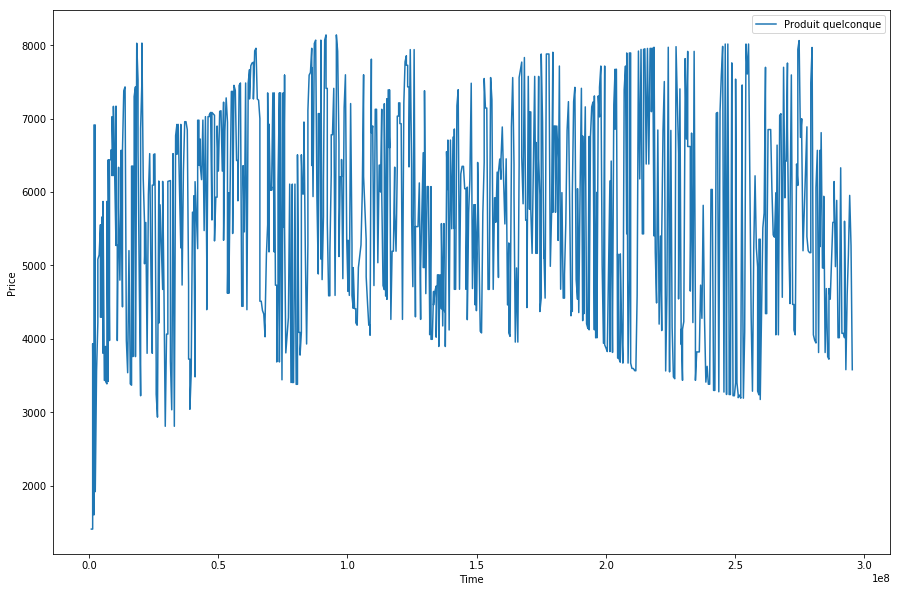

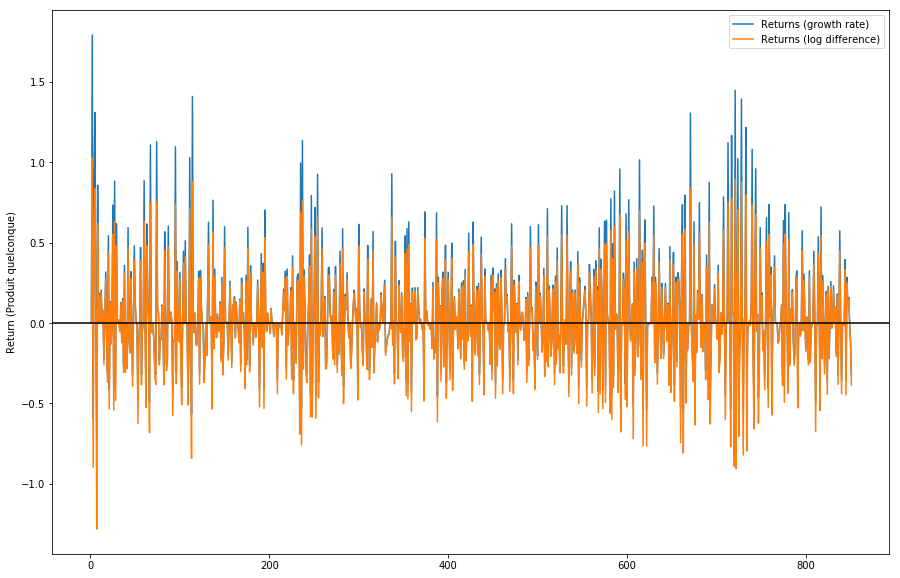

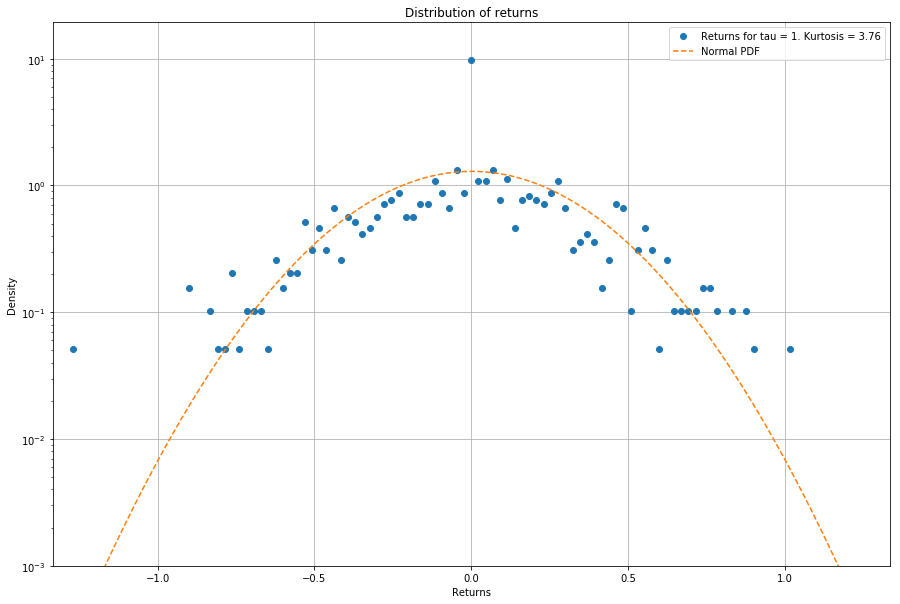

In [34]:
plt.rcParams['figure.figsize'] = (15,10)
file = open('mytrace.dat', 'w')
m = Market(['Produit quelconque'], out=file, fix='S')

ZITs = []

for i in range(20):
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)

    
for i in range(100):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

asset = 'Produit quelconque'
Prices = np.array(extract_prices('mytrace.dat')[asset][1])
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

draw_returns_hist('mytrace.dat', asset, 100)

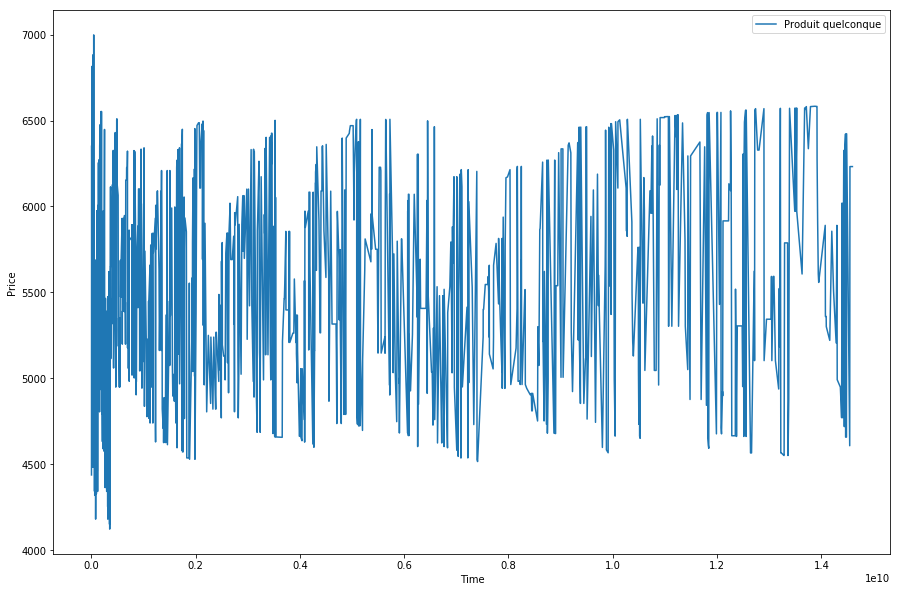

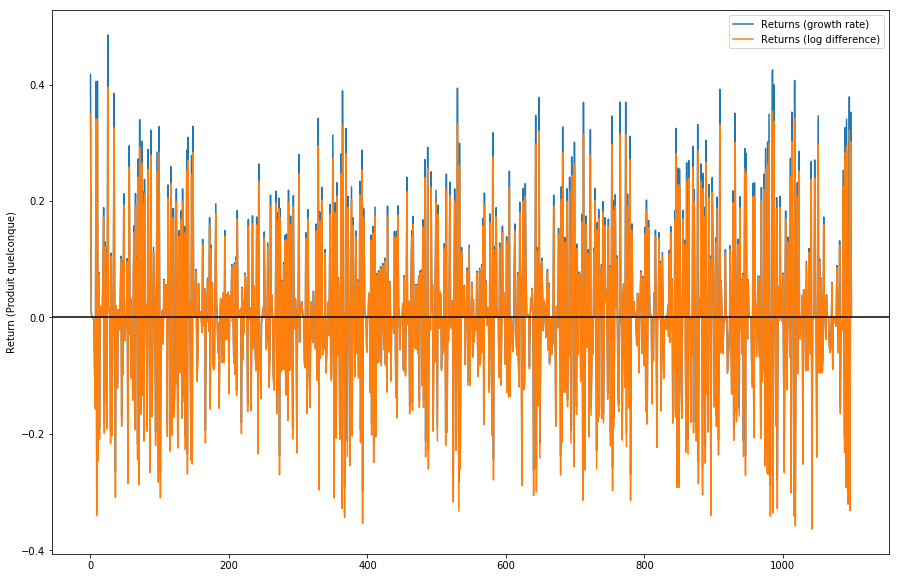

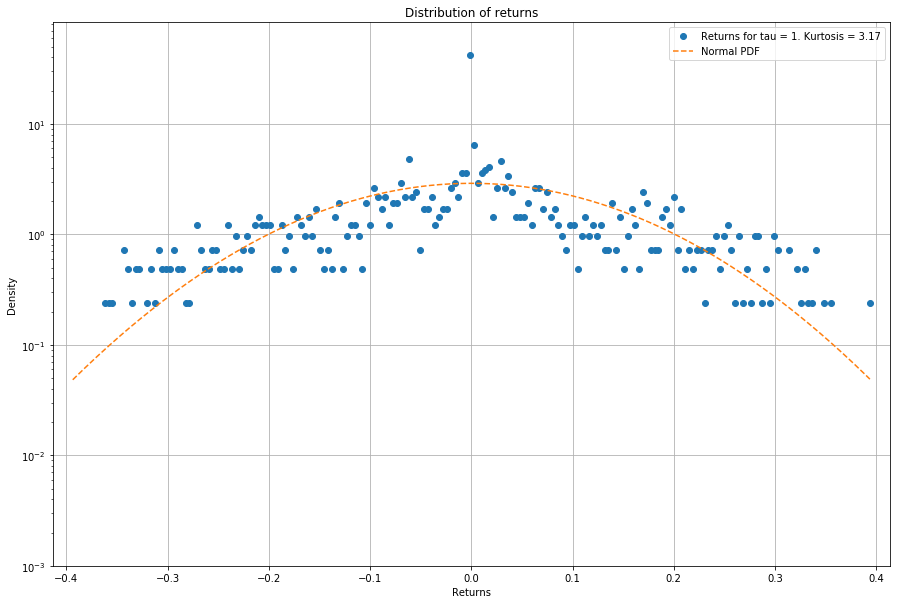

In [61]:
plt.rcParams['figure.figsize'] = (15,10)
file = open('mytrace.dat', 'w')
m = Market(['Produit quelconque'], out=file, fix='S')

ZICs = []

for i in range(100):
    t = ZIC(m,v={'Produit quelconque':random.randint(1000,9999)},waitmax=np.random.randint(3,20))
    ZICs.append(t)
    m.add_trader(t)

    
for i in range(600):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

asset = 'Produit quelconque'
Prices = np.array(extract_prices('mytrace.dat')[asset][1])
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

draw_returns_hist('mytrace.dat', asset, 200)


In [ ]:
file = open('mytrace.dat', 'w')
m = Market(['Produit quelconque'], out=file, fix='S')

ZIPs = []
ZITs = []

for i in range(10):
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)
    
for i in range(50):
    t = ZIP(m,v={'Produit quelconque':random.randint(1000,9999)},momentum=random.random(),beta=(random.random()*0.4)+0.1)
    ZIPs.append(t)
    m.add_trader(t)

    
for i in range(100):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

asset = 'Produit quelconque'
Prices = np.array(extract_prices('mytrace.dat')[asset][1])
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

draw_returns_hist('mytrace.dat', asset, 100)

11
19
13
8
6
10
10
12
15
16
9
7
7
6
7
5
15
13
13
18
13
12
11
13
13
9
14
4
18
17
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-

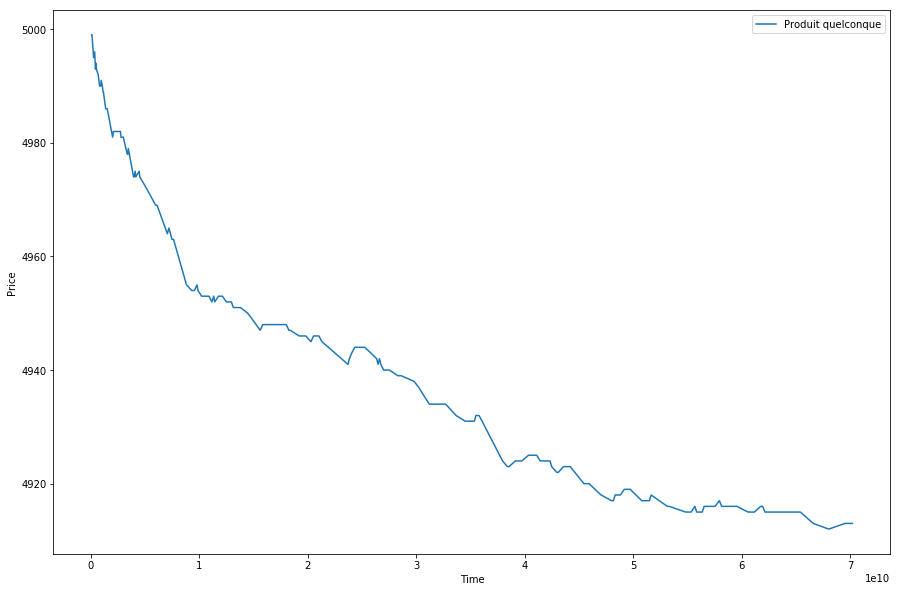

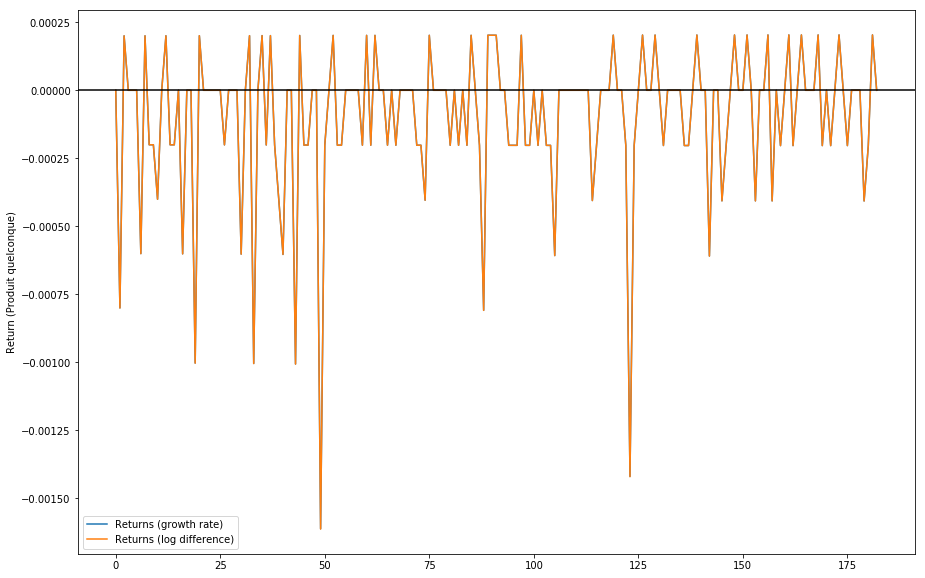

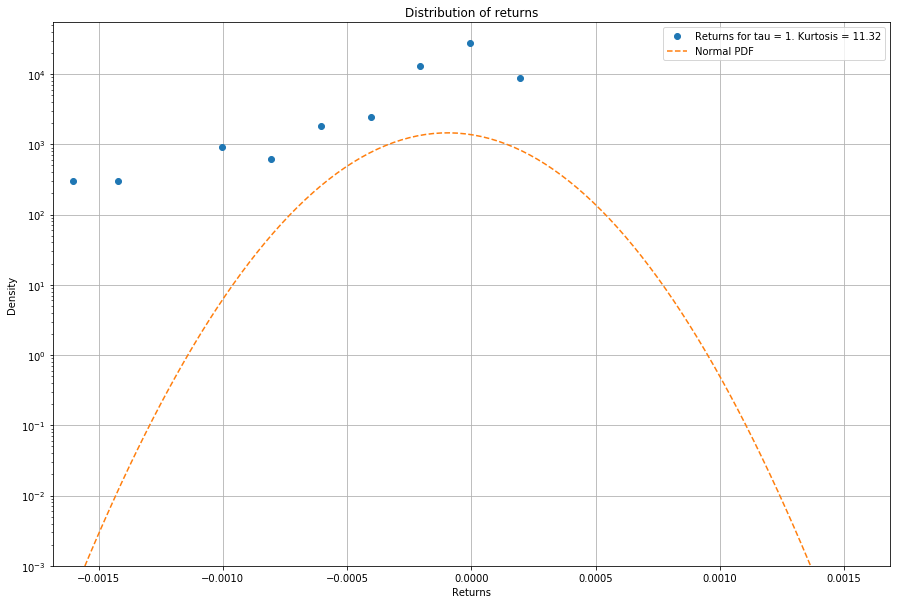

In [63]:
plt.rcParams['figure.figsize'] = (15,10)
file = open('mytrace.dat', 'w')
m = Market(['Produit quelconque'], out=file, fix='S')

GDXs = []
 
ZITs = []


for i in range(30):
    t = GDX(m,v={'Produit quelconque':random.randint(1000,9999)},waitmax=np.random.randint(3,20))
    GDXs.append(t)
    m.add_trader(t)
for i in range(0):   
    m.add_trader(ZITTrader(m))
    
for i in range(200):
    m.run_once()
    print(i,end="-")
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

asset = 'Produit quelconque'
Prices = np.array(extract_prices('mytrace.dat')[asset][1])
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

draw_returns_hist('mytrace.dat', asset, 100)